# APS360 Group 8

This Google Colab includes the everything we used to train our computer vision pipeline, including data preprocessing, training, augmentation, and more. Note that some code portions were done in separate notebooks or run locally. There will be additional Colab links that will lead to the additional code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 0: Baseline Model

We chose an SVM as our baseline model for our image classification task, mainly due to the relatively simpler nature of the problem compared to our object detection. The training code and results for the SVM can be viewed at this link:

https://colab.research.google.com/drive/1A_51XdW3lXZHxt-p-VQ7NAC7piNdS-VH

## Part 1: Training the Image Classifier


### Data Preprocessing


> This portion includes shell scripts that we used to remove duplicates and clean the dataset before augmentation. The code can be accessed at this link:





https://colab.research.google.com/drive/1I5NHdVTj9E4rGB1ZUWz5O2dzfYJAriOt

### Image Augmentation

> Now that we have a clean dataset, we will use the OpenCV library to apply a variety of image augmentation techniques, like rotation, random crop, noise, etc. This will help us build a larger and more robust dataset.



In [1]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

We will choose a single image to demonstrate the effects of the augmentations, and resize the image to 224x224.

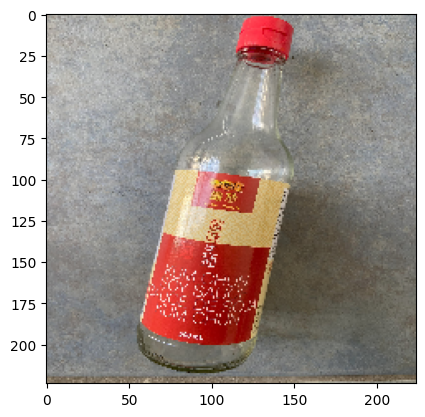

In [ ]:
image_path = "drive/MyDrive/APS360 Group8/Test/glass/glass1.jpg"
original = mpimg.imread(image_path)
original = cv2.resize(original, (224,224))

# Display the image
plt.imshow(original)
plt.show()

We will define five augmentation functions. Crop, color jitter, rotation, blurring, and exposure. We will apply these functions at random across our imbalanced dataset to help fill in the classes with fewer training samples.

In [ ]:
def random_resized_crop(image, size):
    h, w = image.shape[:2]
    left_margin = np.random.randint(0, w - size[0])
    top_margin = np.random.randint(0, h - size[1])
    cropped_image = image[top_margin:top_margin + size[1], left_margin:left_margin + size[0]]
    return cropped_image

def random_color_jitter(image, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    delta_brightness = np.random.uniform(-brightness, brightness)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] + delta_brightness * 255, 0, 255)

    delta_contrast = np.random.uniform(1 - contrast, 1 + contrast)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * delta_contrast, 0, 255)

    delta_saturation = np.random.uniform(1 - saturation, 1 + saturation)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * delta_saturation, 0, 255)

    delta_hue = np.random.uniform(-hue, hue)
    hsv[:, :, 0] = (hsv[:, :, 0] + delta_hue * 360) % 180

    # Convert back from HSV to BGR
    jittered_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return jittered_image

def random_rotation(image, max_angle=180):
    height, width = image.shape[:2]
    angle = np.random.uniform(90, max_angle)
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return rotated_image

def img_blur(image, kernel_size=5):
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return blurred_image

def random_exposure(image, gamma_range=(0.2, 1.0)):
    image_float32 = image.astype(np.float32) / 255.0
    gamma = np.random.uniform(gamma_range[0], gamma_range[1])
    augmented_image_float32 = np.power(image_float32, 0.2)
    augmented_image = (augmented_image_float32 * 255).astype(np.uint8)
    return augmented_image

In [ ]:
# Apply augmentations
augmented_crop = random_resized_crop(original, size=(130, 130))
augmented_jitter = random_color_jitter(original)
augmented_rotation = random_rotation(original)
augmented_blur = img_blur(original)
augmented_exposure = random_exposure(original)

images = [augmented_crop, augmented_jitter, augmented_rotation, augmented_blur, augmented_exposure]
names = ["Crop", "Jitter", "Rotation", "Blur", "Exposure"]

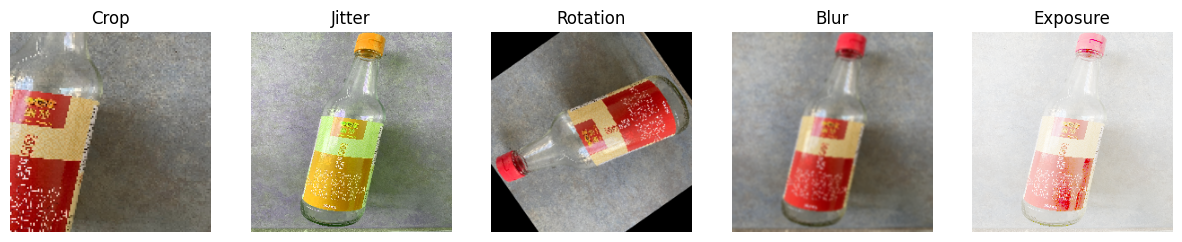

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the image paths and display each image on a subplot
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")
    axes[i].set_title(names[i])

Now we can apply these augmentations to our entire dataset. Let's take a look at which classes are imbalanced:

In [ ]:
import os
dataset_path = 'drive/MyDrive/APS360 Group8/preaugmented_images/content/data/clean'

In [ ]:
items = os.listdir(dataset_path)

classes = [item for item in items if os.path.isdir(os.path.join(dataset_path, item))]
class_sizes = []

In [ ]:
for cl in classes:
    path = dataset_path + '/' + cl
    class_sizes.append(len(os.listdir(path)))

<BarContainer object of 10 artists>

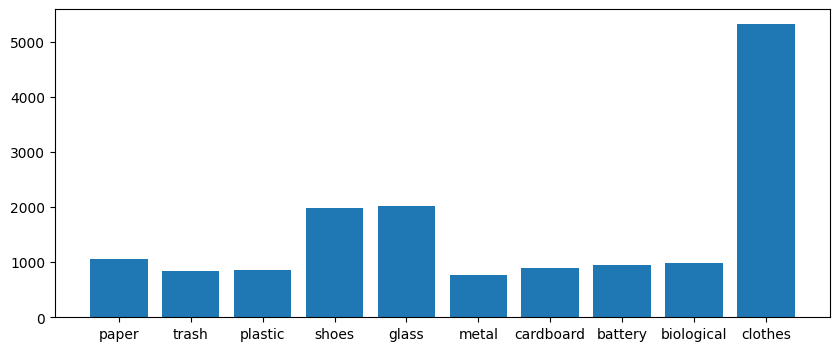

In [ ]:
plt.figure(figsize=(10, 4))
plt.bar(classes, class_sizes)

It seems we have a large class imbalance. This is not good for our model as it will be biased towards a few select classes. We will use our augmentation functions to help balance this out. We will cap each class at 2000 images each. If the current size of the class is below 2000, we will augment the images until it hits the 2000 cap.

In [ ]:
aug_path = 'drive/MyDrive/APS360 Group8/augmented'

In [ ]:
for i in range(1, len(class_sizes)):
    path = dataset_path + '/' + classes[i]
    download_path = aug_path + '/' + classes[i]
    print(download_path)
    count = 0

    for img in os.listdir(path):
        if count >= 2000:
            break
        image_path = path + '/' + img
        image = mpimg.imread(image_path)
        image = cv2.resize(image, (224,224))
        file_name = ""

        if(len(img.split('.')) == 2):
            file_name = img
        else:
            file_name = "(1)" + img.split('.')[0] + '.jpg'

        cv2.imwrite(download_path + '/' + file_name, image)
        count += 1

    #augmenting images
    for img in os.listdir(path):
        #if we already have 2000 images, we break out early and do not augment anything
        if count >= 2000:
            break
        image_path = path + '/' + img
        image = mpimg.imread(image_path)
        image = cv2.resize(image, (224,224))

        #getting augmented images
        augmented_crop = random_resized_crop(image, size=(130, 130))
        augmented_jitter = random_color_jitter(image)
        augmented_rotation = random_rotation(image)
        augmented_blur = img_blur(image)
        augmented_exposure = random_exposure(image)
        file_name = ""

        if(len(img.split('.')) == 2):
            file_name = img
        else:
            file_name = "(1)" + img.split('.')[0] + '.jpg'

        #writing augmented images to file
        cv2.imwrite(download_path + '/' + 'crop' + file_name, augmented_crop)
        cv2.imwrite(download_path + '/' + 'jitter' + file_name, augmented_jitter)
        cv2.imwrite(download_path + '/' + 'rot' + file_name, augmented_rotation)
        cv2.imwrite(download_path + '/' + 'blur' + file_name, augmented_blur)
        cv2.imwrite(download_path + '/' + 'exp' + file_name, augmented_exposure)
        count += 5

    print(count)

drive/MyDrive/APS360 Group8/augmented/trash
2004
drive/MyDrive/APS360 Group8/augmented/plastic
2002
drive/MyDrive/APS360 Group8/augmented/shoes
2002
drive/MyDrive/APS360 Group8/augmented/glass
2000
drive/MyDrive/APS360 Group8/augmented/metal
2003
drive/MyDrive/APS360 Group8/augmented/cardboard
2001
drive/MyDrive/APS360 Group8/augmented/battery
2000
drive/MyDrive/APS360 Group8/augmented/biological
2000
drive/MyDrive/APS360 Group8/augmented/clothes
2000


<BarContainer object of 10 artists>

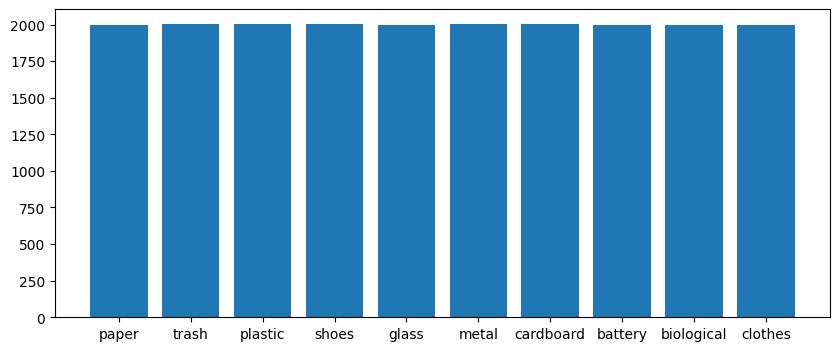

In [ ]:
new_class_sizes = []

for cl in classes:
    path = aug_path + '/' + cl
    new_class_sizes.append(len(os.listdir(path)))

plt.figure(figsize=(10, 4))
plt.bar(classes, new_class_sizes)

We now have a nicely augmented dataset, which is also balanced. The smaller classes now have more samples due to the augmentation process, while the larger classes have been trimmed to reduce bias in our model. We can now begin the training process.

### Training Model


> We will use two pre-trained models for feature extraction, ResNet18 and ResNet152. These models were chosen due to their advanced construction - the skip-connections will definitely help our model overcome gradient issues on our large dataset. The features will then be passed into a fully connected layer for classification.



In [2]:
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F

Everything onwards from here is done on local runtime. The file paths may be different because of this.

In [4]:
dataset = datasets.ImageFolder(root='augmented')

In [5]:
len(dataset)

20012

In [6]:
if torch.cuda.is_available():
    device = torch.cuda.get_device_name(0) # 0 is the GPU device index
    print(f'GPU: {device}')
else:
    print('No GPU available, using CPU.')

GPU: NVIDIA GeForce RTX 3060 Ti


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_classes = 10

In [9]:
class_to_idx = dataset.class_to_idx

In [ ]:
def get_data_loader(batch_size):
    """ Splits the dataset into training and validation datasets.
    Returns data loaders for the two preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch

    Returns:
        dataloaders = {'train': train_loader, 'val': val_loader}
    """

    # Define size
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    # Random split
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    transformation = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset.dataset.transform = transformation
    val_dataset.dataset.transform = transformation

    # Create data loaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

Lets visualize the dataset and take a look at some of the augmentations done to them.

Training data size:  16009
Validation data size:  4003


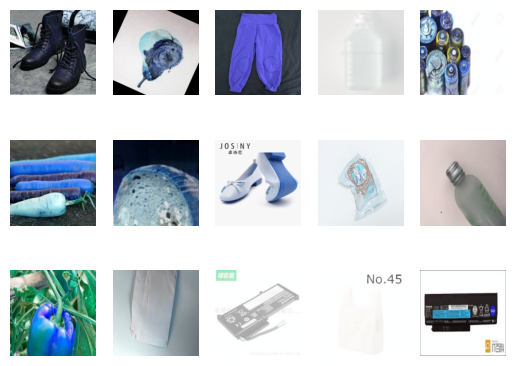

In [ ]:
## Visualize dataset
train_loader, val_loader = get_data_loader(1)

k = 0
for images, labels in train_loader:
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    img = images[0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    k += 1
    if k > 14:
        break

print("Training data size: ", len(train_loader) * train_loader.batch_size)
print("Validation data size: ", len(val_loader) * val_loader.batch_size)

We will train two ResNet models for this classification task, one with 18 layers and one with 152 layers. We will choose the best model from the two training results.

In [ ]:
def get_stats(model, data, criterion):
    total_correct, data_count = 0, 0
    iter, total_loss = 1, 0
    for inputs, labels in data:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += pred.eq(labels.view_as(pred)).sum().item()
        data_count += labels.size(0)
        iter += 1
        total_loss += loss.item()
    return total_correct / data_count, total_loss / iter

def train(model, criterion, optimizer, train, valid, scheduler, model_name, num_epochs=30):
    torch.manual_seed(1000)
    model = model.to(device)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        # for recording training statistics
        data_count = 0
        total_correct = 0
        total_loss = 0
        iter = 1

        predicted_labels = []
        true_labels = []

        for inputs, labels in train:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Split training accuracy calculation here (save time)
            data_count += labels.size(0)
            _, pred = torch.max(outputs, 1)
            total_correct += pred.eq(labels.view_as(pred)).sum().item()
            total_loss += loss.item()
            iter += 1

            # Record decision matrix
            predicted_labels.extend(pred.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        scheduler.step()

        train_acc[epoch] = float(total_correct) / data_count
        train_loss[epoch] = float(total_loss) / iter
        val_acc[epoch], val_loss[epoch] = get_stats(model, valid, criterion)

        print(("Epoch {}: Train accuracy: {}, Validation accuracy: {}").format(
               epoch + 1,
               train_acc[epoch],
               val_acc[epoch]))

        if(epoch == num_epochs - 1):
            conf_matrix = confusion_matrix(true_labels, predicted_labels)
            print("Confusion Matrix:")
            print(np.array(conf_matrix))

    # plot
    plt.title("Training vs Validation Accuracy")
    plt.plot(range(1,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), model_name + '.pth')

In [ ]:
# Get the pre-trained ResNet model
resnet152 = models.resnet152(weights='DEFAULT')
resnet18 = models.resnet18(weights='DEFAULT')

In [ ]:
# Freeze pre-trained layers
for param in resnet152.parameters():
    param.requires_grad = False
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of classes in dataset
resnet152.fc = nn.Linear(resnet152.fc.in_features, num_classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

In [ ]:
train_loader, val_loader = get_data_loader(batch_size=64)

**Training ResNet18**

In [ ]:
# Only train the fc layers
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 1: Train accuracy: 0.7522018864388781, Validation accuracy: 0.8286285286035473
Epoch 2: Train accuracy: 0.8470860141170592, Validation accuracy: 0.8603547339495379
Epoch 3: Train accuracy: 0.86420138671997, Validation accuracy: 0.8661004246814888
Epoch 4: Train accuracy: 0.8750078081079393, Validation accuracy: 0.86535098675993
Epoch 5: Train accuracy: 0.882253732275595, Validation accuracy: 0.873095178616038
Epoch 6: Train accuracy: 0.8831907052283091, Validation accuracy: 0.8773419935048713
Epoch 7: Train accuracy: 0.8901867699419077, Validation accuracy: 0.8755933050212341
Epoch 8: Train accuracy: 0.8885002186270223, Validation accuracy: 0.8818386210342243
Epoch 9: Train accuracy: 0.8901867699419077, Validation accuracy: 0.8770921808643517
Epoch 10: Train accuracy: 0.8954962833406209, Validation accuracy: 0.8815888083937047
Epoch 11: Train accuracy: 0.9053657317758761, Validation accuracy: 0.8858356232825381
Epoch 12: Train accuracy: 0.9054281966393903, Validation accuracy: 0.

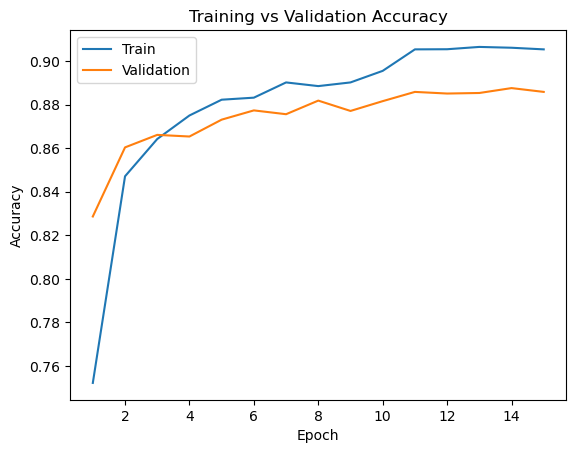

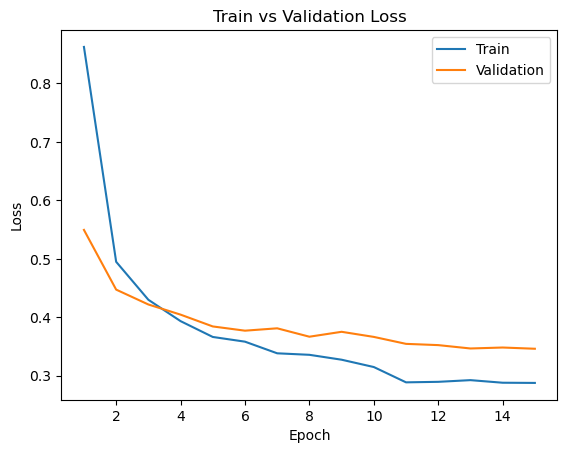

In [ ]:
train(resnet18, criterion, optimizer, train_loader, val_loader, scheduler, model_name="resnet18", num_epochs=15)

**Training ResNet152**

Epoch 1: Train accuracy: 0.8313448685114623, Validation accuracy: 0.8953285036222833
Epoch 2: Train accuracy: 0.9113623586732463, Validation accuracy: 0.9198101423932051
Epoch 3: Train accuracy: 0.9332875257667562, Validation accuracy: 0.932050961778666
Epoch 4: Train accuracy: 0.9424073958398401, Validation accuracy: 0.9367974019485386
Epoch 5: Train accuracy: 0.9478418389655818, Validation accuracy: 0.9385460904321759
Epoch 6: Train accuracy: 0.954275719907552, Validation accuracy: 0.94229328003997
Epoch 7: Train accuracy: 0.9615841089387219, Validation accuracy: 0.9460404696477642
Epoch 8: Train accuracy: 0.9622087575738647, Validation accuracy: 0.9427929053210092
Epoch 9: Train accuracy: 0.9676432006996065, Validation accuracy: 0.943542343242568
Epoch 10: Train accuracy: 0.9713286276469486, Validation accuracy: 0.94229328003997
Confusion Matrix:
[[1580    0    5    0    3    5    3    2    0    4]
 [   0 1618    2    0    0    1    0    0    0    2]
 [   7    5 1552    1    1    4 

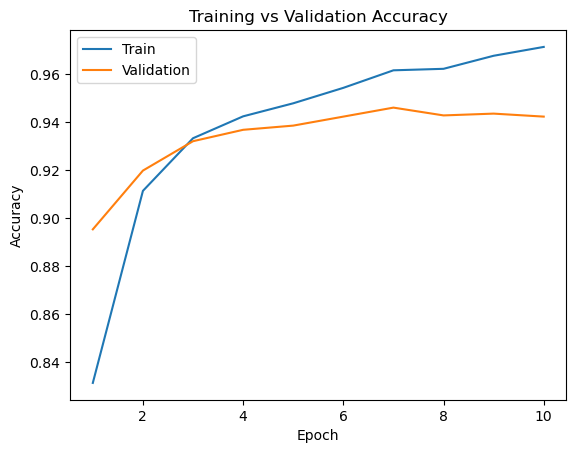

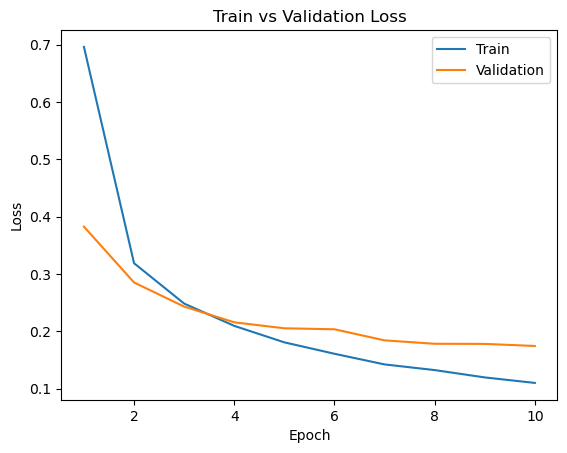

In [ ]:
optimizer = optim.Adam(resnet152.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train(resnet152, criterion, optimizer, train_loader, val_loader, scheduler, model_name="resnet152", num_epochs=10)

### Testing Model


> Resnet152 provided the best validation accuracy out of the two, which isn't surprising since it contains a lot more layers. We can now use the models for inference by loading it from the saved .pth files. Let's compare the test accuracy between the two models.



In [10]:
path_152 = "resnet152.pth"
path_18 = "resnet18.pth"
weights_152 = torch.load(path_152)
weights_18 = torch.load(path_18)

In [11]:
model_18 = models.resnet18(weights='DEFAULT')
for param in model_18.parameters():
    param.requires_grad = False

model_18.fc = nn.Linear(model_18.fc.in_features, num_classes)
model_18.load_state_dict(weights_18)
model_18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
model_152 = models.resnet152(weights='DEFAULT')
for param in model_152.parameters():
    param.requires_grad = False

model_152.fc = nn.Linear(model_152.fc.in_features, num_classes)
model_152.load_state_dict(weights_152)
model_152.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
test_path = "Custom Test Images/Custom Test Images"

def get_test_loader(batch_size, path):
    transformation = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_folder = datasets.ImageFolder(root=test_path, transform=transformation)
    print(test_folder.class_to_idx)
    # Create data loaders for each set
    test_loader = torch.utils.data.DataLoader(test_folder, batch_size=batch_size, shuffle=True)

    return test_loader

test_loader = get_test_loader(batch_size=64, path=test_path)

{'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [ ]:
accuracy_18 = get_stats(model_18, test_loader, criterion)
accuracy_152 = get_stats(model_152, test_loader, criterion)

In [ ]:
accuracy_18

(0.4581818181818182, 1.4489389459292095)

In [ ]:
accuracy_152

(0.6, 1.2064940134684246)

It seems both models performed quite poorly on our testing dataset, with the highest accuracy being that of ResNet152, with a 60% accuracy score. This was quite unexpected due to the high validation accuracy during training. This will be further explored in our report.

Let's test our model on a few select images and see what it predicts. This will hopefully give us some insight into how the model thinks.

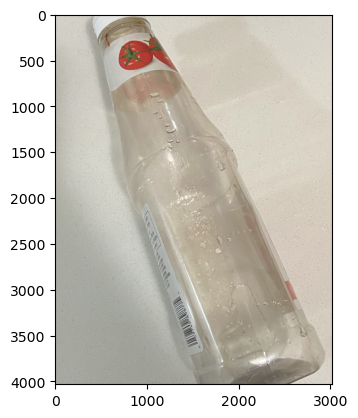

In [ ]:
testimg1 = "Custom Test Images/Custom Test Images/plastic/plastic11.jpg" #class plastic
testimg2 = "Custom Test Images/Custom Test Images/paper/paper15.jpg" #class trash
img1 = Image.open(testimg1)
img2 = Image.open(testimg2)

plt.imshow(img1)

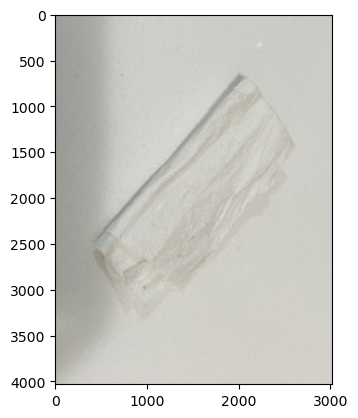

In [ ]:
plt.imshow(img2)

We will test this individual image on ResNet152.

In [ ]:
dataset.class_to_idx

{'battery': 0,
 'biological': 1,
 'cardboard': 2,
 'clothes': 3,
 'glass': 4,
 'metal': 5,
 'paper': 6,
 'plastic': 7,
 'shoes': 8,
 'trash': 9}

In [13]:
def get_prediction(image):
    preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
    input_batch = input_batch.to(device)

    with torch.no_grad():
        output = model_152(input_batch)

    _, predicted_class = torch.max(output, 1)
    return predicted_class

In [ ]:
print("Predicted Class:", get_prediction(img1).item())

Predicted Class: 7


In [ ]:
print("Predicted Class:", get_prediction(img2).item())

Predicted Class: 9


In this case, img1 was predicted correctly, but img2 was incorrect (it was class 6 paper, but predicted as class 9 trash).

Here is the confusion matrix for ResNet152.

In [ ]:
def get_confusion(model, data, criterion):
    total_correct, data_count = 0, 0
    iter, total_loss = 1, 0
    predicted_labels = []
    true_labels = []
    for inputs, labels in data:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += pred.eq(labels.view_as(pred)).sum().item()
        data_count += labels.size(0)
        iter += 1
        total_loss += loss.item()
        predicted_labels.extend(pred.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(np.array(conf_matrix))

get_confusion(model_152, test_loader, criterion)

Confusion Matrix:
[[17  2  0  0  4  5  0  3  0  2]
 [ 0 11  0  0  0  0  0  5  0  4]
 [ 2  0  9  0  0  0  5  0  0  2]
 [ 0  1  2 20  0  0  1  0  0  0]
 [ 0  1  0  0 13  8  0  2  1  0]
 [ 4  0  0  5  5 17  0  0  0  1]
 [ 2  0  5  2  0  2 14  0  0  7]
 [ 2  1  3  1  5  3  1 14  0  1]
 [ 0  0  1  0  0  0  0  0 31  0]
 [ 3  0  3  0  3  4  1  1  2 11]]


## Part 2: Training the object detection algorithm (YoloV8)

We used a completely different dataset to train our object detection algorithm, which can be found here: https://www.kaggle.com/datasets/kneroma/tacotrashdataset

These images came with bounding boxes that represented the location of waste within the image. We had to format the images and their boxes in the YOLO format, using .yaml files and specific directory structures. We then trained YoloV8 on this custom dataset. The data processing is attached at this Colab Link.

https://colab.research.google.com/drive/1nMdTqRv231QndZETy1qx4goAFcTWWMfu

Additionally, the training and testing code can be found at this link here.

https://colab.research.google.com/drive/1xRKZyBCBZpElrEnUCQoHlMSwAZz2mH04

We also tried to train a different model with the "detecto" library, but this model didn't work out in the end due to GPU memory issues. The training and processing code can be found here if interested.

https://colab.research.google.com/drive/1QgTY7h3csmT8wRXMHAtt-LCPRi2_kVth

## Part 3: Pipeline Demonstration

Now that the two models are completed, we can load them into this colab and perform inference. Let's grab a single image and run it through our prototype pipeline. For a real-life application, much of this process would be automated through tools like Amazon Web Services, Docker, and other cloud computing resources. For this simple example, we will just be writing our outputs to a file.

In [14]:
import os

In [23]:
input_folder = 'pipeline_input'
for i in os.listdir(input_folder):
    print(i)

test1.jpg


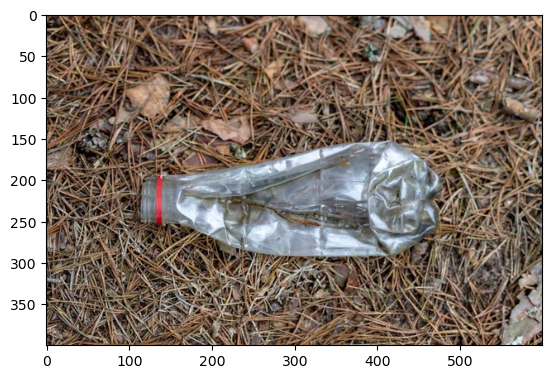

In [24]:
img = input_folder + '/' + 'test1.jpg'
img = Image.open(img)
plt.imshow(img)

In a real implementation, we would have an automatic trigger once an image enters this folder to start the analytics process.

First, we determine the location of the waste in the image. This is done with our YoloV8 model.

In [16]:
from ultralytics import YOLO

In [ ]:
!yolo task=detect mode=predict model=runs/detect/train32/weights/best.pt conf=0.25 source="pipeline_input"

Ultralytics YOLOv8.0.221 ðŸš€ Python-3.10.9 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
Model summary (fused): 218 layers, 25850182 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 A:\Github\pipeline_input\test1.jpg: 288x416 1 waste1, 1 waste12, 144.0ms
Speed: 1.5ms preprocess, 144.0ms inference, 241.5ms postprocess per image at shape (1, 3, 288, 416)
Results saved to runs\detect\predict2
ðŸ’¡ Learn more at https://docs.ultralytics.com/modes/predict


Now, we move to the next stage in the pipeline: classification.

In [38]:
idx_to_class = {value: key for key, value in class_to_idx.items()}

In [39]:
prediction = idx_to_class[int(get_prediction(img))]

In [40]:
prediction

'plastic'

Now, we can write this to a file with the same filename as the object detection image.

In [41]:
result_path = 'runs\detect\predict2'
with open(result_path + '/' + 'test1.txt', 'w') as file:
    file.write(prediction + '\n')

And we're done! Now to access the image and its results we simply need the key to find it in the folder, which in this case is "test1".

In [42]:
key = 'test1'
detect_img = result_path + '/' + key + '.jpg'
detect_img = Image.open(detect_img)

with open(result_path + '/' + key + '.txt', 'r') as file:
    cl = file.read()

Text(0.5, 1.0, 'plastic\n')

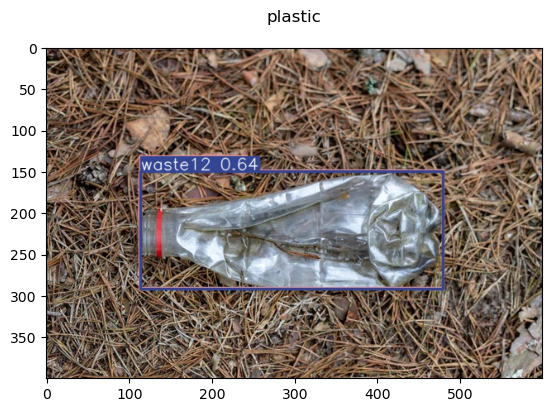

In [43]:
plt.imshow(detect_img)
plt.title(cl)